In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
def get_reviews_and_ratings_from_page(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        review_containers = soup.find_all('div', class_='review-container')

        reviews = []
        ratings = []

        for container in review_containers:
            review_text = container.find('div', class_='text show-more__control').get_text()
            reviews.append(review_text)
            rating = container.find('span', class_='rating-other-user-rating')
            if rating:
                star_rating = rating.find_all('span')[0].get_text()
                ratings.append(star_rating)
            else:
                ratings.append(None)
        
        return reviews, ratings
    else:
        print(f"Failed to retrieve the page. Status code: {response.status_code}")
        return [], []

In [3]:
base_url = "https://www.imdb.com/title/tt15239678/reviews/_ajax?ref_=undefined&paginationKey="
url = "https://www.imdb.com/title/tt15239678/reviews/?ref_=ttrt_ql_2"

In [4]:
reviews, ratings = get_reviews_and_ratings_from_page(url)

# If more reviews exist, continue collecting them
while len(reviews) < 2000:
    soup = BeautifulSoup(requests.get(url, headers={"User-Agent": "Mozilla/5.0"}).content, 'html.parser')
    next_button = soup.find('div', class_='load-more-data')
    if not next_button:
        break
    key = next_button['data-key']
    next_url = base_url + key
    new_reviews, new_ratings = get_reviews_and_ratings_from_page(next_url)
    reviews.extend(new_reviews)
    ratings.extend(new_ratings)
    if len(reviews) >= 2000:
        reviews = reviews[:2000]
        ratings = ratings[:2000]
        break

In [5]:
df = pd.DataFrame({
    'Review': reviews,
    'Rating': ratings
})

In [6]:
not_null_mask = df['Rating'].notnull()
df.loc[not_null_mask, 'Rating'] = df.loc[not_null_mask, 'Rating'].astype(int)

In [7]:
df['Rating'].fillna(df['Rating'].mean(), inplace=True)
df.to_csv('imdb_reviews and ratings.csv', index=False)

C:\Users\ACER\AppData\Local\Temp\ipykernel_24456\2969992095.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Rating'].fillna(df['Rating'].mean(), inplace=True)
C:\Users\ACER\AppData\Local\Temp\ipykernel_24456\2969992095.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Rating'].fillna(df['Rating'].

In [8]:
df = pd.read_csv('imdb_reviews and ratings.csv')
df.isna().sum()

Review    0
Rating    0
dtype: int64

In [9]:
df["Sentiment"] = df['Rating'].apply(lambda x: 'Positive' if x > 5 else 'Negative' )

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

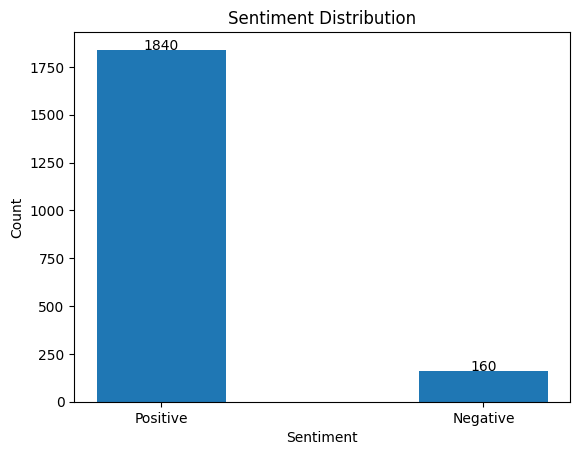

In [11]:
plt.bar(df['Sentiment'].value_counts().index, df['Sentiment'].value_counts().values, width=0.4,) 
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

for i in range(len(df['Sentiment'].value_counts().values)):
    plt.text(i, df['Sentiment'].value_counts().values[i], df['Sentiment'].value_counts().values[i], ha = 'center')

In [12]:
df.to_csv('Sentiment_Data.csv', index=False)